In [2]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader,TensorDataset
import copy
from sklearn.model_selection import train_test_split
import torchvision
import matplotlib.pyplot as plt
from IPython import display
display.set_matplotlib_formats('svg')

<ipython-input-2-bc4a5a901d40>:11: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  display.set_matplotlib_formats('svg')


In [3]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [4]:
emnistData= torchvision.datasets.EMNIST(root='emnist',split='letters',download=True)
# split = 'letters' will choose letters only from this dataset it also contains numbers


In [5]:
print(emnistData.classes)
print(type(emnistData.classes))
print(type(emnistData.data))
print(emnistData.data.shape)
print(emnistData.data)

['N/A', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']
<class 'list'>
<class 'torch.Tensor'>
torch.Size([124800, 28, 28])
tensor([[[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]],

        [[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]],

        [[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]],

        ...,

        [[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]

In [6]:
print(emnistData.data.dtype)
images=emnistData.data.view([-1,1,28,28]).float()
images.dtype

torch.uint8


torch.float32

In [7]:
emnistData.class_to_idx
# we want to remove the N/A

{'N/A': 0,
 'a': 1,
 'b': 2,
 'c': 3,
 'd': 4,
 'e': 5,
 'f': 6,
 'g': 7,
 'h': 8,
 'i': 9,
 'j': 10,
 'k': 11,
 'l': 12,
 'm': 13,
 'n': 14,
 'o': 15,
 'p': 16,
 'q': 17,
 'r': 18,
 's': 19,
 't': 20,
 'u': 21,
 'v': 22,
 'w': 23,
 'x': 24,
 'y': 25,
 'z': 26}

In [8]:
letterCategories = emnistData.classes[1:]
labels = copy.deepcopy(emnistData.targets)-1
print(torch.sum(labels==0))
print(torch.sum(emnistData.targets==0))

tensor(4800)
tensor(0)


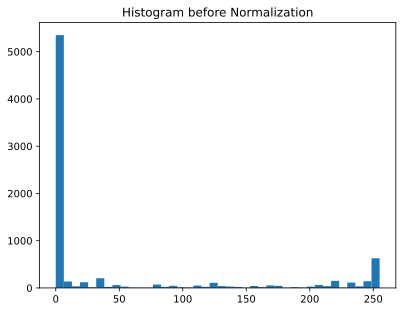

In [9]:
# visualization plt.hist takes a dimention full of values to show the freq of each value i took first 10 data items since it will be 10*28*28 and the 2nd parameter is 40 bins

plt.hist(images[:10].view(-1),40)
plt.title('Histogram before Normalization')
plt.show()

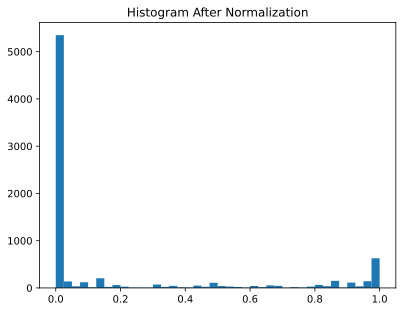

In [10]:
#Normalization
images/=torch.max(images)
# gets a the max value of all of the tensor values
plt.hist(images[:10].view(-1),40)
plt.title('Histogram After Normalization')
plt.show()